## CatBoost Classifier Summary (v3 · Model Comparison Baseline)

### Feature 구성 요약

- 전체 feature 개수 (모델 입력 기준): **83**
- 수치형 feature 개수: **75**
- 범주형 feature 개수: **8**

#### 범주형 feature 목록 (명시적 지정)

- `city`
- `gender`
- `registered_via`
- `last_payment_method`
- `has_ever_paid`
- `has_ever_cancelled`
- `is_auto_renew_last`
- `is_free_user`

> 범주형 feature는 의미적으로 **코드/상태 변수**에 해당하므로  
> dtype 자동 추론을 사용하지 않고, **사전에 명시적으로 지정**함.


---

### Feature Table 사용 원칙

- 본 실험에서는 **사전에 확정된 user-level feature table**을 그대로 사용
- 노트북에서는:
  - feature 추가 ❌
  - feature 제거 ❌
  - 결측치 처리 ❌
- 모델별 전처리는 **학습 시점 파이프라인**에서만 수행

> 데이터 정합성은 feature table 단계에서 이미 보장된 상태이며,  
> 본 노트북은 **모델 비교 목적의 baseline 실험**에 한정됨.


---

### CatBoost 전처리 파이프라인

- Feature 분리:
  - 수치형/범주형을 사전에 분리
  - `cat_features` 인덱스를 명시적으로 전달

- 범주형 처리:
  - pandas `astype(str).astype('category')` 변환
  - CatBoost가 내부적으로 target encoding 처리

- 통합:
  - `Pool(X, y, cat_features=...)` 형태로 전달


---

### 실험 설정 요약

- 분류 모델: `catboost.CatBoostClassifier`
- 클래스 불균형 대응: `auto_class_weights="Balanced"`
- 결정 임계값 (threshold): **0.5 (고정)**
- 목적:
  - CatBoost native categorical 성능을 baseline으로 비교


---

### 데이터 분할 방식

- 분할 방식:
  - Stratified random split (`stratify = is_churn`)
  - `random_state = 719`

- 분할 구조:
  - **Train / Test split (80 / 20)**
  - Validation set 미사용 (모델 체급 비교 단계)

- 분할 기준:
  - user-level feature table
  - 각 row는 고유 사용자(`msno`) 단위


---

### CatBoost Hyperparameters

- `iterations`: 4000
- `learning_rate`: 0.03
- `depth`: 6
- `loss_function`: "Logloss"
- `eval_metric`: "PRAUC"
- `auto_class_weights`: "Balanced"
- `random_seed`: 719
- `early_stopping_rounds`: 200
- `verbose`: False


---

### 평가 지표 (Test set 기준)

- **PR-AUC**
- **Recall (Churn = 1)**
- **Accuracy**
- Confusion Matrix
- Classification Report
- Feature Importance 시각화


---

### 요약

- 본 모델은 **모델 간 비교를 위한 baseline 중 하나**
- 동일한 데이터 분할과 평가 지표로 Logistic Regression 대비 체급 비교 수행
- 결과 이미지는 `../images/models/catboost/` 경로에 저장됨


# Scores (test)


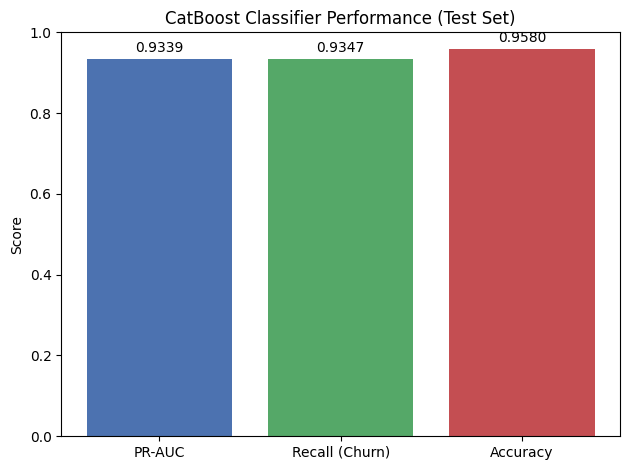

In [1]:
import matplotlib.pyplot as plt
import os

names = ["PR-AUC", "Recall (Churn)", "Accuracy"]
values = [0.9339, 0.9347, 0.9580]
colors = ["#4C72B0", "#55A868", "#C44E52"]

plt.figure()
bars = plt.bar(names, values, color=colors)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("CatBoost Classifier Performance (Test Set)")

for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, v + 0.01, "{:.4f}".format(v), ha="center", va="bottom")

os.makedirs("../images/models/catboost", exist_ok=True)
plt.tight_layout()
plt.savefig("../images/models/catboost/fig_catboost_metrics_scores.png", dpi=300)
plt.show()


# Confusion matrix (test)


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrices(
    cm: np.ndarray,
    title: str,
    labels=("Non-churn (0)", "Churn (1)"),
    save_path: str | None = None,
):
    sns.set_theme(style="white", font_scale=1.1)

    cm = np.array(cm, dtype=int)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8))

    ax = axes[0]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        linewidths=0.5,
        linecolor="white",
        square=True,
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
    )
    ax.set_title(f"{title}\nCounts", weight="bold", pad=10)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    ax = axes[1]
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2%",
        cmap="Blues",
        cbar=True,
        linewidths=0.5,
        linecolor="white",
        square=True,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        ax=ax,
    )
    ax.set_title(f"{title}\nRow-normalized", weight="bold", pad=10)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()



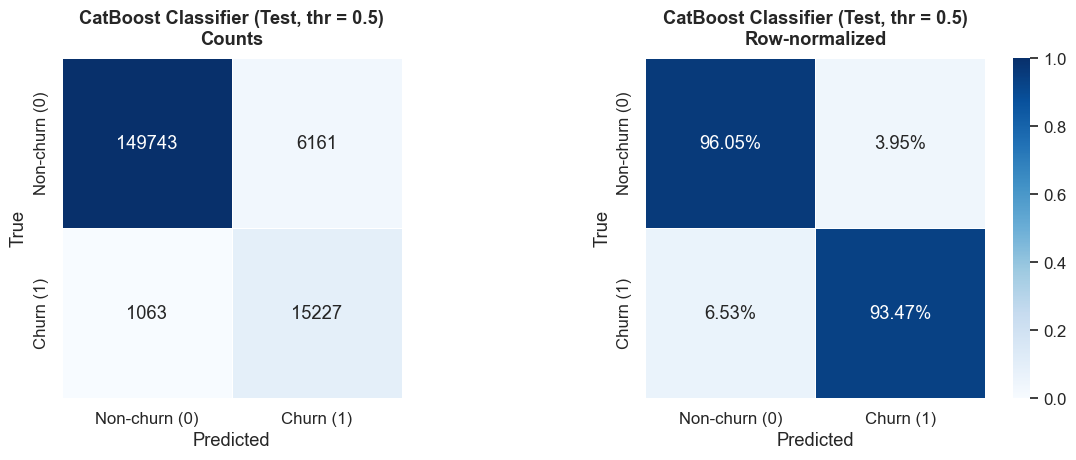

In [3]:
import numpy as np

default_cm = np.array([[149743, 6161], [1063, 15227]])

plot_confusion_matrices(
    cm=default_cm,
    title="CatBoost Classifier (Test, thr = 0.5)",
    save_path="../images/models/catboost/fig_catboost_confusion_test.png",
)


# Feature importance


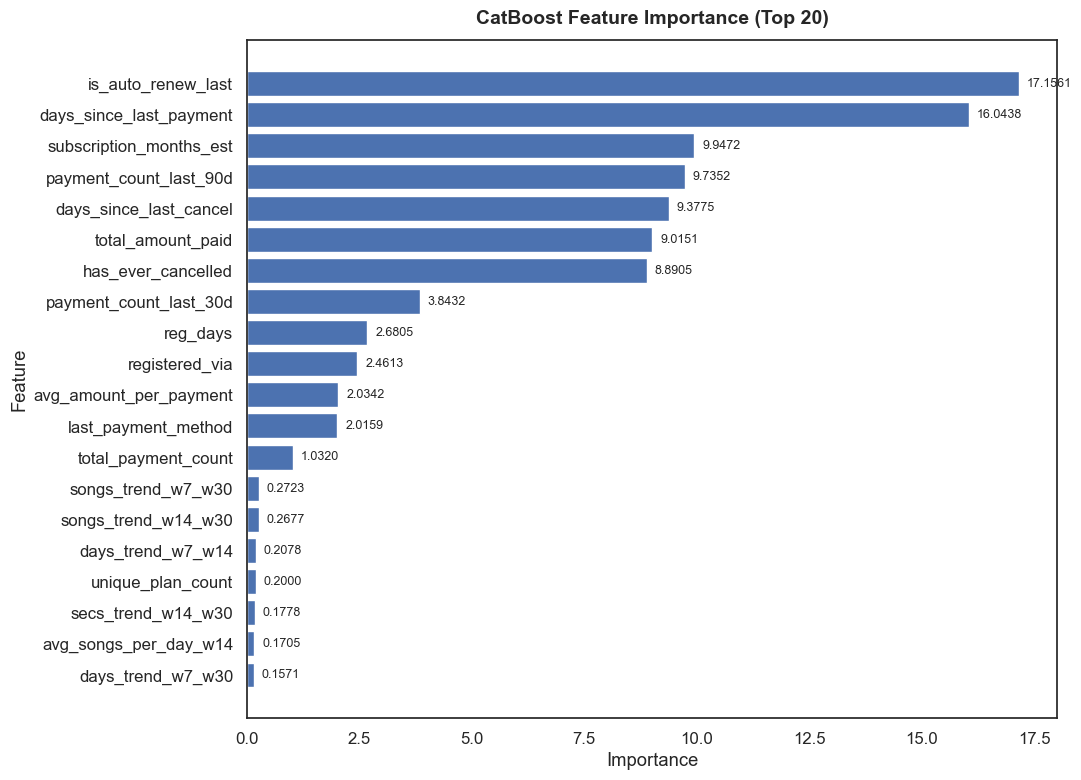

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_feature_importance_topN(
    csv_path: str,
    top_n: int = 20,
    title: str = "CatBoost Feature Importance (Top 20)",
    save_path: str | None = "../images/models/catboost/fig_catboost_feature_importance_top20.png",
):
    df = pd.read_csv(csv_path)
    required = {"feature", "importance"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(
            "Missing required columns: {}. Found columns: {}".format(missing, list(df.columns))
        )

    top = (
        df.sort_values("importance", ascending=False)
          .head(top_n)
          .iloc[::-1]
          .reset_index(drop=True)
    )

    plt.figure(figsize=(11, 8))
    ax = plt.gca()
    ax.barh(top["feature"], top["importance"], color="#4C72B0")

    ax.set_title(title, fontsize=14, weight="bold", pad=12)
    ax.set_xlabel("Importance")
    ax.set_ylabel("Feature")

    x_min, x_max = ax.get_xlim()
    pad = (x_max - x_min) * 0.01
    for i, v in enumerate(top["importance"]):
        ax.text(v + pad, i, "{:.4f}".format(v), va="center", ha="left", fontsize=9)

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


plot_feature_importance_topN(
    csv_path="../data/model_df/catboost_feature_importance.csv",
    top_n=20,
    title="CatBoost Feature Importance (Top 20)",
    save_path="../images/models/catboost/fig_catboost_feature_importance_top20.png",
)
